<h1> Importing the Libraries</h1>

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tools.eval_measures import rmse, aic

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import warnings
warnings.filterwarnings("ignore")

<h1> Warnings</h1>

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
pd.plotting.register_matplotlib_converters()
np.set_printoptions(suppress=True)

<h1> Reading Data</h1>

In [3]:
df=pd.read_csv("covid19_italy_region.csv")
df.head()

,SNo,Date,Country,RegionCode,RegionName,Latitude,Longitude,HospitalizedPatients,IntensiveCarePatients,TotalHospitalizedPatients,HomeConfinement,CurrentPositiveCases,NewPositiveCases,Recovered,Deaths,TotalPositiveCases,TestsPerformed
0,1,2020-04-19T17:00:00,ITA,13,Abruzzo,42.351222,13.398438,317,40,357,1630,1987,34,276,258,2521,22424
1,2,2020-04-19T17:00:00,ITA,17,Basilicata,40.639471,15.805148,59,8,67,180,247,3,71,24,342,6528
2,3,2020-04-19T17:00:00,ITA,18,Calabria,38.905976,16.594402,142,6,148,696,844,24,116,75,1035,22234
3,4,2020-04-19T17:00:00,ITA,15,Campania,40.839566,14.250850,590,61,651,2371,3022,41,703,304,4029,34994
4,5,2020-04-19T17:00:00,ITA,8,Emilia-Romagna,44.494367,11.341721,3166,289,3455,10097,13552,376,5985,3023,22560,88776


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4872 entries, 0 to 4871
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SNo                        4872 non-null   int64  
 1   Date                       4872 non-null   object 
 2   Country                    4872 non-null   object 
 3   RegionCode                 4872 non-null   int64  
 4   RegionName                 4872 non-null   object 
 5   Latitude                   4872 non-null   float64
 6   Longitude                  4872 non-null   float64
 7   HospitalizedPatients       4872 non-null   int64  
 8   IntensiveCarePatients      4872 non-null   int64  
 9   TotalHospitalizedPatients  4872 non-null   int64  
 10  HomeConfinement            4872 non-null   int64  
 11  CurrentPositiveCases       4872 non-null   int64  
 12  NewPositiveCases           4872 non-null   int64  
 13  Recovered                  4872 non-null   int64

In [5]:
#Inuptting missing values with mean value in Tests performed column
df['TestsPerformed'] = df['TestsPerformed'].fillna( df['TestsPerformed'].median() )

In [6]:
# Checking the percentage of missing data in each column
missing=df.isna().sum()*100/len(df)
missing.sort_values(ascending=False)

SNo                          0.0
TotalHospitalizedPatients    0.0
TotalPositiveCases           0.0
Deaths                       0.0
Recovered                    0.0
NewPositiveCases             0.0
CurrentPositiveCases         0.0
HomeConfinement              0.0
IntensiveCarePatients        0.0
Date                         0.0
HospitalizedPatients         0.0
Longitude                    0.0
Latitude                     0.0
RegionName                   0.0
RegionCode                   0.0
Country                      0.0
TestsPerformed               0.0
dtype: float64

In [7]:
#Checking the period covered by data
df["Date"]=pd.to_datetime(df["Date"]).dt.normalize()
(df.Date.max()-df.Date.min())+datetime.timedelta(days=1)

Timedelta('232 days 00:00:00')

In [8]:
#Grouping Date with other columns of data 
VAR_DF=df.groupby("Date")[['HospitalizedPatients', 'IntensiveCarePatients', 'TotalHospitalizedPatients',
                                      'HomeConfinement', 'CurrentPositiveCases', 'NewPositiveCases',
                                      'Recovered', 'Deaths', 'TotalPositiveCases', 'TestsPerformed']].sum().reset_index()

In [9]:
VAR_DF.shape

(232, 11)

In [10]:
VAR_DF.head(20)

,Date,HospitalizedPatients,IntensiveCarePatients,TotalHospitalizedPatients,HomeConfinement,CurrentPositiveCases,NewPositiveCases,Recovered,Deaths,TotalPositiveCases,TestsPerformed
0,2020-04-19,25033,2635,27668,80589,108257,3047,47055,23660,178972,935310
1,2020-04-20,24906,2573,27479,80758,108237,2256,48877,24114,181228,943151
2,2020-04-21,24134,2471,26605,81104,107709,2729,51600,24648,183957,971246
3,2020-04-22,23805,2384,26189,81510,107699,3370,54543,25085,187327,1015494
4,2020-04-23,22871,2267,25138,81710,106848,2646,57576,25549,189973,1052577
5,2020-04-24,22068,2173,24241,82286,106527,3021,60498,25969,192994,1147850
6,2020-04-25,21533,2102,23635,82212,105847,2357,63120,26384,195351,1186526
7,2020-04-26,21372,2009,23381,82722,106103,2324,64928,26644,197675,1210639
8,2020-04-27,20353,1956,22309,83504,105813,1739,66624,26977,199414,1237317
9,2020-04-28,19723,1863,21586,83619,105205,2091,68941,27359,201505,1274871


In [11]:
#Dropping the Columns who are aprt of the other columns(e.g.
# TotalHospitalizedPatients = HospitalizedPatients + IntensiveCarePatients)
VAR_DF.drop(['HospitalizedPatients', 'IntensiveCarePatients', 'NewPositiveCases', 'TotalPositiveCases', 'CurrentPositiveCases'],
          axis=1, inplace=True)

In [12]:
VAR_DF.head()

,Date,TotalHospitalizedPatients,HomeConfinement,Recovered,Deaths,TestsPerformed
0,2020-04-19,27668,80589,47055,23660,935310
1,2020-04-20,27479,80758,48877,24114,943151
2,2020-04-21,26605,81104,51600,24648,971246
3,2020-04-22,26189,81510,54543,25085,1015494
4,2020-04-23,25138,81710,57576,25549,1052577


In [13]:
type(VAR_DF["Date"])

pandas.core.series.Series

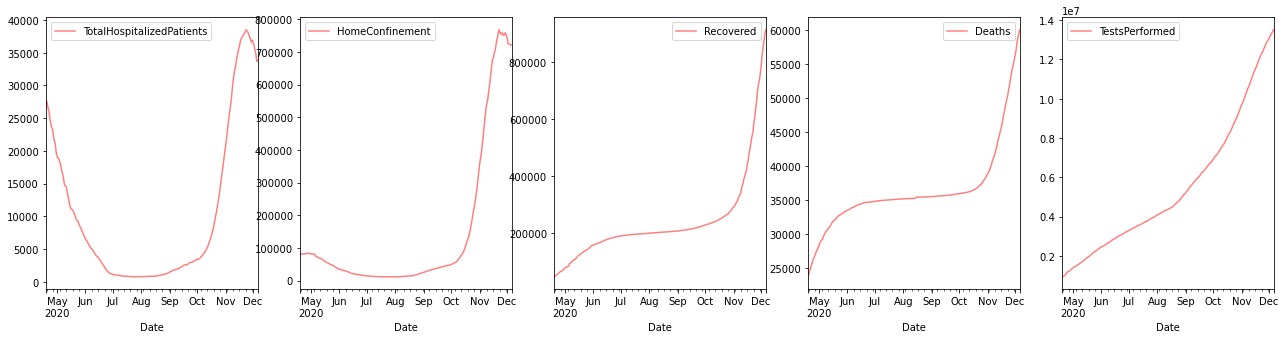

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(22,5))

for ycol, ax in zip(['TotalHospitalizedPatients', 'HomeConfinement',
                                                  'Recovered', 'Deaths', 'TestsPerformed'], axes):

    VAR_DF.plot(kind='line', x='Date', y=ycol, ax=ax, alpha=0.5, color='r')

<h1>VAR</h1>
Checking for Causlity
Granger causality is a concept of causality derived from the notion that causes may not occur after effects and that if one variable is the cause of another, knowing the status on the cause at an earlier point in time can enhance prediction of the effect at a later point in time (Granger, 1969; Lütkepohl, 2005, p. 41) 

In [15]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False, maxlag=5):    
    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. 

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df  

In [16]:
grangers_causation_matrix(VAR_DF, variables = ['TotalHospitalizedPatients', 'HomeConfinement',
                                                  'Recovered', 'Deaths', 'TestsPerformed']) 

,TotalHospitalizedPatients_x,HomeConfinement_x,Recovered_x,Deaths_x,TestsPerformed_x
TotalHospitalizedPatients_y,1.0,0.0000,0.0,0.0,0.000
HomeConfinement_y,0.0,1.0000,0.0,0.0,0.000
Recovered_y,0.0,0.0000,1.0,0.0,0.001
Deaths_y,0.0,0.0000,0.0,1.0,0.001
TestsPerformed_y,0.0,0.0013,0.0,0.0,1.000


The test Null Hypothesis is that the coefficients of the corresponding past values are zero; That is the X does not cause Y. The P-values in the table are lesser than our significance level (0.05), which implies that the Null Hypothesis can be rejected.

<h1> Checking for Cointegration</h1>

Cointegration tests analyze non-stationary time series— processes that have variances and means that vary over time. In other words, the method allows you to estimate the long-run parameters or equilibrium in systems with unit root variables (Rao, 2007).

In [17]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [18]:
cointegration_test(VAR_DF[['TotalHospitalizedPatients', 'HomeConfinement',
                                                  'Recovered', 'Deaths', 'TestsPerformed']])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
TotalHospitalizedPatients ::  287.66    > 60.0627   =>   True
HomeConfinement ::  116.56    > 40.1749   =>   True
Recovered ::  52.65     > 24.2761   =>   True
Deaths ::  21.24     > 12.3212   =>   True
TestsPerformed ::  1.86      > 4.1296    =>   False


<h1> Train-Test Split</h1>

In [19]:
test_frec = 0.25
n_test = round((len(VAR_DF)) * test_frec)
df_train, df_test = VAR_DF[0:-n_test], VAR_DF[-n_test:]
# df_train_copy = df_train.copy()
df_train.drop('Date',1, inplace=True)

<b>Unit Root Test (checking for stationaity)</b>

In statistics, a unit root test tests whether a time series variable is non-stationary and possesses a unit root. The null hypothesis is generally defined as the presence of a unit root and the alternative hypothesis is either stationarity, trend stationarity or explosive root depending on the test used.

In [20]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [21]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "TotalHospitalizedPatients" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.56
 No. Lags Chosen       = 14
 Critical value 1%     = -3.472
 Critical value 5%     = -2.88
 Critical value 10%    = -2.577
 => P-Value = 0.5036. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "HomeConfinement" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.5965
 No. Lags Chosen       = 7
 Critical value 1%     = -3.47
 Critical value 5%     = -2.879
 Critical value 10%    = -2.576
 => P-Value = 0.4854. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Recovered" 
    -----------------------------------------------


In [22]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [23]:
# ADF Test on each column
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "TotalHospitalizedPatients" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9615
 No. Lags Chosen       = 14
 Critical value 1%     = -3.472
 Critical value 5%     = -2.88
 Critical value 10%    = -2.577
 => P-Value = 0.0386. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "HomeConfinement" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.246
 No. Lags Chosen       = 6
 Critical value 1%     = -3.47
 Critical value 5%     = -2.879
 Critical value 10%    = -2.576
 => P-Value = 0.9747. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Recovered" 
    -----------------------------------------------
 Null Hypothesis: Data

In [24]:
# 1st difference
df_differenced = df_differenced.diff().dropna()

In [25]:
# ADF Test on each column
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "TotalHospitalizedPatients" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.3517
 No. Lags Chosen       = 14
 Critical value 1%     = -3.473
 Critical value 5%     = -2.88
 Critical value 10%    = -2.577
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "HomeConfinement" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.3266
 No. Lags Chosen       = 5
 Critical value 1%     = -3.47
 Critical value 5%     = -2.879
 Critical value 10%    = -2.576
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Recovered" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

As you can see, after 2 series differences, we have 2 stationary columns under significance level of 5%, 1 stationary column under significance level of 0.1%, and 2 non-stationary columns (under plausible significance level). This is not ideal - however, because we're using "short" time series, I've decided to go on with only 2 diffrences and not to add more differences.

In [26]:
model = VAR(df_differenced[['TotalHospitalizedPatients', 'HomeConfinement',
                                                  'Recovered', 'Deaths', 'TestsPerformed']])

fitted = model.fit(6)
fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 28, May, 2021
Time:                     13:06:17
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    59.0392
Nobs:                     166.000    HQIC:                   57.3129
Log likelihood:          -5681.80    FPE:                2.44391e+24
AIC:                      56.1335    Det(Omega_mle):     1.03823e+24
--------------------------------------------------------------------
Results for equation TotalHospitalizedPatients
                                  coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
const                               23.485067         8.114789            2.894           0.004
L1.TotalHospitalizedPatients        -0.558196         0.098135           -5.

Choosing number of lags to be inserted into the model is a matter of trial and error, and can be changed according to the regression results (above), the durbin-watson test results (will be explained in a moment), and other metrics (e.g., RMSE, MAE, etc.)

<b>Checking for Residuals' Autocorrelaotion</b>

We'll use Durbin-Watson test for this (denoted as d):

The value of d always lies between 0 and 4.

d = 2 indicates no autocorrelation.

If d < 2, there is evidence of positive serial correlation. As a rough rule of thumb, if d < 1.0, there may be cause > for alarm. Small values of d indicate successive error terms are positively correlated.

If d > 2, successive error terms are negatively correlated. In regressions, this can imply an underestimation of the > level of statistical significance.

In [27]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(fitted.resid)

for col, val in zip(VAR_DF[['TotalHospitalizedPatients', 'HomeConfinement',
                                                  'Recovered', 'Deaths', 'TestsPerformed']], out):
    print(col, ':', round(val, 2))

TotalHospitalizedPatients : 1.93
HomeConfinement : 1.9
Recovered : 1.87
Deaths : 2.04
TestsPerformed : 1.81


<b>Forecasting</b>

In [28]:
# Get the lag order
lag_order = fitted.k_ar

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[    22.,    272.,   -550.,     -9., -10266.],
       [   132.,   -521.,     70.,     -2., -22815.],
       [   -86.,   -157.,    651.,     12.,  25962.],
       [    41.,   1170.,   -214.,      3.,  17874.],
       [   -11.,    945.,   -144.,     -9., -11402.],
       [    26.,    756.,    126.,      6.,   8857.]])

In [29]:
var_df_forecast = VAR_DF[['TotalHospitalizedPatients', 'HomeConfinement',
                                                  'Recovered', 'Deaths', 'TestsPerformed']]

fc = fitted.forecast(y=forecast_input, steps=n_test)
df_forecast = pd.DataFrame(fc, index=var_df_forecast.index[-n_test:], columns=var_df_forecast.columns + '_2d')
df_forecast.head()

,TotalHospitalizedPatients_2d,HomeConfinement_2d,Recovered_2d,Deaths_2d,TestsPerformed_2d
174,-207.765435,80.818957,439.398304,64.192015,2936.736638
175,238.879895,470.977113,-360.820269,6.977526,-8756.030083
176,-46.254158,315.918598,-63.947225,34.853549,-8976.964055
177,-68.572747,-284.065865,897.326046,28.293783,17394.919770
178,87.297985,1050.948553,-311.242044,36.355290,12586.082063


In [30]:
def invert_transformation(df_train, df_forecast, second_diff=False, third_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 3rd Diff
        if third_diff:
            df_fc[str(col)+'_2d'] = (df_train[col].iloc[-2]-df_train[col].iloc[-3]) + df_fc[str(col)+'_3d'].cumsum()
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [31]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True, third_diff=False)        
df_results.loc[:, ['TotalHospitalizedPatients_forecast', 'HomeConfinement_forecast',
                                                  'Recovered_forecast', 'Deaths_forecast', 'TestsPerformed_forecast']]

,TotalHospitalizedPatients_forecast,HomeConfinement_forecast,Recovered_forecast,Deaths_forecast,TestsPerformed_forecast
174,4455.234565,6.968582e+04,239174.398304,36203.192015,7.524372e+06
175,4676.349026,7.420562e+04,240438.976338,36302.361556,7.596394e+06
176,4851.209328,7.904133e+04,241639.607148,36436.384645,7.659440e+06
177,4957.496883,8.359298e+04,243737.564005,36598.701518,7.739881e+06
178,5151.082423,8.919558e+04,245524.278817,36797.373680,7.832908e+06
179,5388.667399,9.549225e+04,247252.904537,37021.236780,7.924682e+06
180,5528.334974,1.020702e+05,249342.607764,37233.546762,8.019277e+06
181,5679.210730,1.093400e+05,251252.864356,37506.363970,8.115558e+06
182,5948.731819,1.169344e+05,253137.848557,37805.153025,8.207599e+06
183,6183.185028,1.246742e+05,255398.610764,38120.248396,8.296691e+06


In [32]:
df_results.head()

,TotalHospitalizedPatients_2d,HomeConfinement_2d,Recovered_2d,Deaths_2d,TestsPerformed_2d,TotalHospitalizedPatients_1d,TotalHospitalizedPatients_forecast,HomeConfinement_1d,HomeConfinement_forecast,Recovered_1d,Recovered_forecast,Deaths_1d,Deaths_forecast,TestsPerformed_1d,TestsPerformed_forecast
174,-207.765435,80.818957,439.398304,64.192015,2936.736638,-17.765435,4455.234565,4048.818957,69685.818957,1625.398304,239174.398304,92.192015,36203.192015,80778.736638,7.524372e+06
175,238.879895,470.977113,-360.820269,6.977526,-8756.030083,221.114461,4676.349026,4519.796070,74205.615026,1264.578035,240438.976338,99.169541,36302.361556,72022.706554,7.596394e+06
176,-46.254158,315.918598,-63.947225,34.853549,-8976.964055,174.860302,4851.209328,4835.714668,79041.329694,1200.630810,241639.607148,134.023090,36436.384645,63045.742499,7.659440e+06
177,-68.572747,-284.065865,897.326046,28.293783,17394.919770,106.287555,4957.496883,4551.648803,83592.978497,2097.956856,243737.564005,162.316872,36598.701518,80440.662269,7.739881e+06
178,87.297985,1050.948553,-311.242044,36.355290,12586.082063,193.585540,5151.082423,5602.597356,89195.575853,1786.714812,245524.278817,198.672163,36797.373680,93026.744331,7.832908e+06


In [33]:
df_test.head()

,Date,TotalHospitalizedPatients,HomeConfinement,Recovered,Deaths,TestsPerformed
174,2020-10-10,4726,70103,238525,36140,7523702
175,2020-10-11,4939,74136,239709,36166,7592410
176,2020-10-12,5273,77491,240600,36205,7652059
177,2020-10-13,5590,81603,242028,36246,7722319
178,2020-10-14,6009,86436,244065,36289,7809920


In [40]:
df_results.head()

,TotalHospitalizedPatients_2d,HomeConfinement_2d,Recovered_2d,Deaths_2d,TestsPerformed_2d,TotalHospitalizedPatients_1d,TotalHospitalizedPatients_forecast,HomeConfinement_1d,HomeConfinement_forecast,Recovered_1d,Recovered_forecast,Deaths_1d,Deaths_forecast,TestsPerformed_1d,TestsPerformed_forecast,Date
174,-207.765435,80.818957,439.398304,64.192015,2936.736638,-17.765435,4455.234565,4048.818957,69685.818957,1625.398304,239174.398304,92.192015,36203.192015,80778.736638,7.524372e+06,2020-10-10
175,238.879895,470.977113,-360.820269,6.977526,-8756.030083,221.114461,4676.349026,4519.796070,74205.615026,1264.578035,240438.976338,99.169541,36302.361556,72022.706554,7.596394e+06,2020-10-11
176,-46.254158,315.918598,-63.947225,34.853549,-8976.964055,174.860302,4851.209328,4835.714668,79041.329694,1200.630810,241639.607148,134.023090,36436.384645,63045.742499,7.659440e+06,2020-10-12
177,-68.572747,-284.065865,897.326046,28.293783,17394.919770,106.287555,4957.496883,4551.648803,83592.978497,2097.956856,243737.564005,162.316872,36598.701518,80440.662269,7.739881e+06,2020-10-13
178,87.297985,1050.948553,-311.242044,36.355290,12586.082063,193.585540,5151.082423,5602.597356,89195.575853,1786.714812,245524.278817,198.672163,36797.373680,93026.744331,7.832908e+06,2020-10-14


<b> Results Visualization</b>

In [35]:
df_results['Date'] = VAR_DF['Date'][174:232]


In [36]:
df_test.set_index('Date',inplace=True)

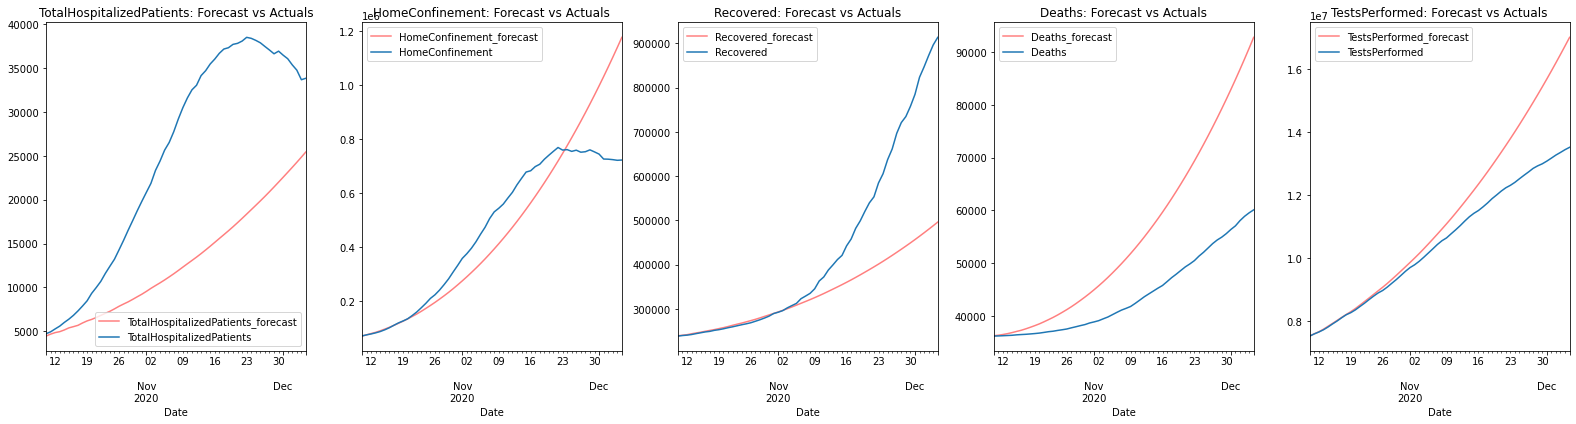

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(22,6))

for col, ax in zip(['TotalHospitalizedPatients', 'HomeConfinement',
                                                  'Recovered', 'Deaths', 'TestsPerformed'], axes):

    df_results.plot(kind='line', y=[col+'_forecast'], x='Date', ax=ax, alpha=0.5, color='r', legend=True).autoscale(axis='x',tight=True)
    df_test[col][-n_test:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
plt.tight_layout();

In [38]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [39]:
print('Forecast Accuracy of: TotalHospitalizedPatients')
accuracy_prod = forecast_accuracy(df_results['TotalHospitalizedPatients_forecast'].values, df_test['TotalHospitalizedPatients'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: HomeConfinement')
accuracy_prod = forecast_accuracy(df_results['HomeConfinement_forecast'].values, df_test['HomeConfinement'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: Recovered')
accuracy_prod = forecast_accuracy(df_results['Recovered_forecast'].values, df_test['Recovered'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: Deaths')
accuracy_prod = forecast_accuracy(df_results['Deaths_forecast'].values, df_test['Deaths'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: TestsPerformed')
accuracy_prod = forecast_accuracy(df_results['TestsPerformed_forecast'].values, df_test['TestsPerformed'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: TotalHospitalizedPatients
mape :  0.4306
me :  -11904.873
mae :  11904.873
mpe :  -0.4306
rmse :  13891.6403
corr :  0.8925
minmax :  0.4306

Forecast Accuracy of: HomeConfinement
mape :  0.17
me :  3315.8943
mae :  98099.6696
mpe :  -0.0279
rmse :  143908.356
corr :  0.9066
minmax :  0.1499

Forecast Accuracy of: Recovered
mape :  0.146
me :  -93905.8939
mae :  95842.9069
mpe :  -0.1386
rmse :  161565.5729
corr :  0.9794
minmax :  0.146

Forecast Accuracy of: Deaths
mape :  0.2296
me :  11273.6292
mae :  11273.6292
mpe :  0.2296
rmse :  14659.8029
corr :  0.9986
minmax :  0.1727

Forecast Accuracy of: TestsPerformed
mape :  0.0677
me :  836624.2307
mae :  836624.2307
mpe :  0.0677
rmse :  1296092.5257
corr :  0.9872
minmax :  0.0591


<p>Considering the length of our data, the results seems to be reasonable (altough not perfect :)).

It might be the case that the model predictions will be better, as we get more updated data to feed into the model.</p>